# Lecture 03 - Geocentric Models

In [11]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2025-05-10T16:48:33.094755+07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.36.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy      : 1.12.0
statsmodels: 0.14.4
numpy      : 1.25.2
matplotlib : 3.10.1
xarray     : 2025.4.0
IPython    : 8.36.0
pymc       : 5.8.0
arviz      : 0.16.1
pandas     : 2.2.3
watermark  : 2.5.0



## Linear Regression
- Geocentric
    - unreasonably good approximations, despite it always being incorrect
    - can be used as a cog in a causal analysis system, despite being an innacurate mechanistic model of real phenomena
- Gaussian
    - General error model
    - Abstracts away details, allowing us to make macro inferences, without having to incorporate micro phenomena

## Why Normal?
### Two arguments
1. Generative: summed fluctuations tend toward Normal distribution (see below)
2. Inferential: For estimating mean and variance, the Normal is the least informative (fewest assumptions), in the maximum entropy sense

    > Variables do not need to be Normally-distributed in order to estimate the correct mean and variance using a Gaussian error model.

### Generating Normal distribution from summation of decisions
- Simulate a group of people randomly walking left-right, starting from a central location
- Resulting positions are the summation of many left-and-right deviations -- the result is Normally-distributed
- Normal distribution falls out of processes where deviations are summed (also products)

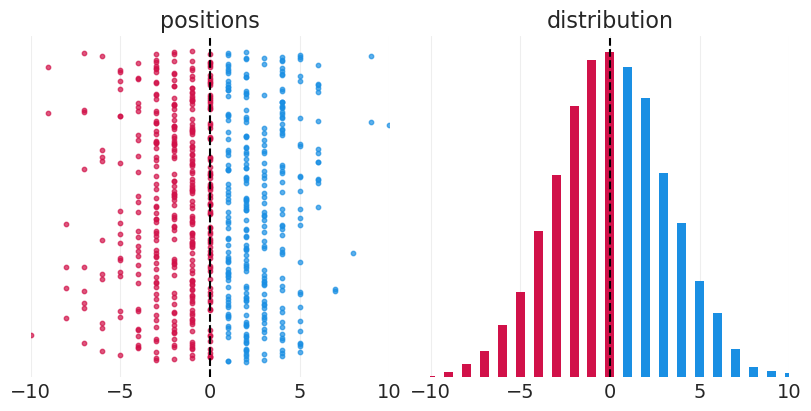

In [12]:
n_people = 10_000
n_steps = 1000

step_size = .1
left_right_step_decisions = (2 * stats.bernoulli(p=.5).rvs(size=(n_people, n_steps)) - 1)
steps = step_size * left_right_step_decisions

positions = np.round(np.sum(steps, axis = 1))
fig, axs = plt.subplots(1, 2, figsize=(8,4))

plt.sca(axs[0])
plt.axvline(0, color='k', linestyle='--')
for ii, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x=pos, y=ii, color=color, alpha=.7, s=10)
    
plt.xlim([-10, 10])
plt.yticks([])
plt.title("positions")

# Plot histogram
position_unique, position_counts = np.unique(positions, return_counts=True)
positive_idx = position_unique > 0
negative_idx = position_unique <= 0
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width=.5, color='C1');
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width=.5, color='C0');
plt.axvline(0, color='k', linestyle='--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");

## Drawing the Owl
1. State clear **question** -- establish an **estimand**
2. Sketch causal **assumptions** -- draw the DAG
3. Define a **generative model** based on causal assumptions -- generate synthetic data
4. Use generative model to build (AND TEST) and **estimator** -- can we recover the data-generating parameters of (3)?
5. Profit: through analyzing real data (possibly gaining insights to iterate on assumptions, model, and/or estimator)

## Linear Regression
### Howell Dataset
#### (1) Question & Estimand
- Describe the association between **weight** and **height**
- We'll focus on **adult weight** -- Adult height is approximately linear

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


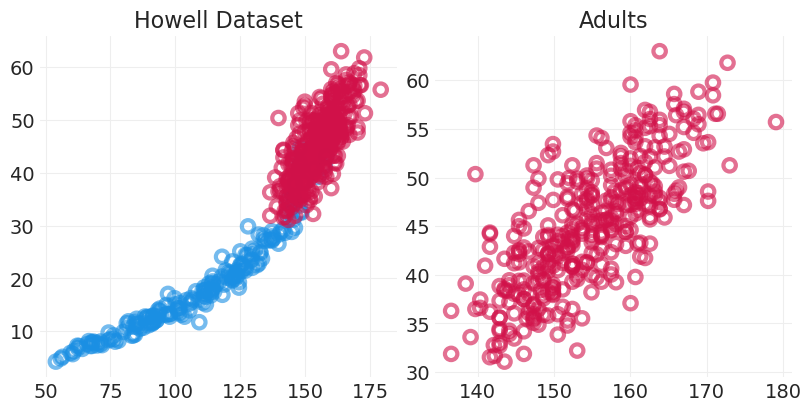

In [15]:
HOWELL = utils.load_data("Howell1")
fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ADULTS = HOWELL.age >= 18
ADULT_HOWELL = HOWELL[ADULTS]
CHILD_HOWELL = HOWELL[~ADULTS]
plt.sca(axs[0])
utils.plot_scatter(CHILD_HOWELL.height, CHILD_HOWELL.weight, color = 'C1')
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Howell Dataset")

plt.sca(axs[1])
utils.plot_scatter(ADULT_HOWELL.height, ADULT_HOWELL.weight)
plt.title("Adults")
HOWELL.head()

#### (2) Scientific Model
How does **height** influence **weight**?
$$
H \rightarrow W \\
W = f(H)
$$
i.e. *Weight is some function of height*

#### (3) Generative Models
Options
1. Dynamic - relationship changes over time
2. Statis - constant trend over time
$$ W = f(H, U) $$
*"Weight $W$ is a function of height, $H$ and some unobserved stuff, $U$"*

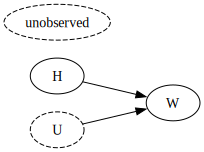

In [18]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("U", "W")
    ],
    node_props={
        "U": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)